In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import nan
from numpy import isnan
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LassoCV
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [5]:
def plotOccurence(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label]).plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Count')
    plt.grid(axis='y',linestyle='-')
    #plt.title(colname+" vs "+label+" count")

In [6]:
def plotProportion(data,colname,label):
    plot=pd.crosstab(index=data[colname],columns=data[label],normalize='index').plot(kind='bar',stacked=True,figsize=(16,5))
    plt.xlabel(colname)
    plt.ylabel('Proportion')
    plt.grid(axis='y',linestyle='-')
    #plt.title(colname+" vs "+label+" proportion")

In [7]:
def plotScatter(data,colname,label):
    plt.scatter(data[colname], data[label], alpha=0.005)
    #plt.yscale('sqrt')
    plt.ylabel(label)
    plt.xlabel(colname)
    plt.title(colname+" vs "+label)
    plt.ylim(1, 50)

In [8]:
def printResults(r2score,mae,mse,rmse):
    print("R2-Score:",r2score)
    print("MAE:",mae)
    print("MSE:",mse)
    print("RMSE:",rmse)

In [9]:
def plotGroupby(data, colname,label):
    ''' 
    LOS by categorical data 
    '''  
    size = (8,4)
    results = data[[colname, label]].groupby(colname).median().reset_index()
    values = list(results[label].values)
    labels = list(results[colname].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#2f5ca5', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median LOS (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title(colname+" vs "+label)
    
    plt.tight_layout()
    plt.show();

In [10]:
def createModel(X_train, X_test, y_train, y_test, model):
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    return {
            'r2score':r2_score(y_test, y_pred),
            'mae': mean_absolute_error(y_test, y_pred),
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': mean_squared_error(y_test, y_pred,squared=False)
           }

In [11]:
def buildAndEvaluateModelKfold(df,label,nFolds,model):
    X1=df
    y1=X1[label]
    kfolds = KFold(n_splits=nFolds)
    r2score=0
    mae=0
    mse=0
    rmse=0
    for train_mask, test_mask in kfolds.split(X1,y1):
        train_fold=X1.iloc[train_mask]
        test_fold=X1.iloc[test_mask]

        y_train=train_fold[label]

        train_fold.drop(columns=label,axis=1,inplace=True)
        X_train=train_fold

        y_test=test_fold[label]
        test_fold.drop(columns=label,axis=1,inplace=True)
        X_test=test_fold

        result=createModel(X_train, X_test, y_train, y_test,model)

        r2score+=result['r2score']*0.1
        mae+=result['mae']*0.1
        mse+=result['mse']*0.1
        rmse+=result['rmse']*0.1
    
    printResults(r2score,mae,mse,rmse)

In [12]:
# load data from files
# Hospital admission related info
df_admission = pd.read_csv('ADMISSIONS.csv')

df_admission.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [13]:
df_admission.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,4/9/2196 12:26,4/10/2196 15:54,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,4/9/2196 10:06,4/9/2196 13:24,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,9/3/2153 7:15,9/8/2153 19:10,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,10/18/2157 19:34,10/25/2157 14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,6/6/2139 16:14,6/9/2139 12:48,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,11/2/2160 2:06,11/5/2160 14:55,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,11/2/2160 1:01,11/2/2160 4:27,ACUTE CORONARY SYNDROME,0,1


In [14]:
df_admission.drop(columns=['ROW_ID','LANGUAGE','EDREGTIME','EDOUTTIME','HOSPITAL_EXPIRE_FLAG','HAS_CHARTEVENTS_DATA'],inplace = True)

df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS
0,22,165315,4/9/2196 12:26,4/10/2196 15:54,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE
1,23,152223,9/3/2153 7:15,9/8/2153 19:10,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
2,23,124321,10/18/2157 19:34,10/25/2157 14:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS
3,24,161859,6/6/2139 16:14,6/9/2139 12:48,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION
4,25,129635,11/2/2160 2:06,11/5/2160 14:55,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME


In [15]:
# Converting ADMITTIME and DISCHTIME to datatime type
df_admission['ADMITTIME'] = pd.to_datetime(df_admission['ADMITTIME'])
df_admission['DISCHTIME'] = pd.to_datetime(df_admission['DISCHTIME'])

# Get the LOS as number of days from discharge and admit time, 86400 seconds in a day
numSeconds = 24*60*60
df_admission['LOS'] = (df_admission['DISCHTIME'] - df_admission['ADMITTIME']).dt.total_seconds()/numSeconds
#ADMITTIME and DISCHTIME can be dropped
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028


In [16]:
df_admission['LOS'].describe()

count    58976.000000
mean        10.133916
std         12.456682
min         -0.945139
25%          3.743750
50%          6.467014
75%         11.795139
max        294.660417
Name: LOS, dtype: float64

In [17]:
df_admission[df_admission.LOS < 0].describe()

,SUBJECT_ID,HADM_ID,LOS
count,98.000000,98.000000,98.000000
mean,30025.785714,152770.336735,-0.290072
std,28055.501190,28955.020962,0.221997
min,181.000000,101946.000000,-0.945139
25%,9270.000000,130047.250000,-0.412500
50%,20731.000000,152006.500000,-0.247222
75%,32360.250000,181287.250000,-0.108681
max,99207.000000,198555.000000,-0.000694


In [18]:
# total 98 rows of -ve LOS which can be dropped
df_admission = df_admission[df_admission['LOS'] >= 0]
df_admission.describe()

,SUBJECT_ID,HADM_ID,LOS
count,58878.000000,58878.000000,58878.000000
mean,33761.791382,149966.149886,10.151266
std,28092.613275,28882.995648,12.459774
min,2.000000,100001.000000,0.001389
25%,11999.250000,124942.750000,3.755556
50%,24141.000000,149987.000000,6.489583
75%,53862.750000,174958.000000,11.805556
max,99999.000000,199999.000000,294.660417


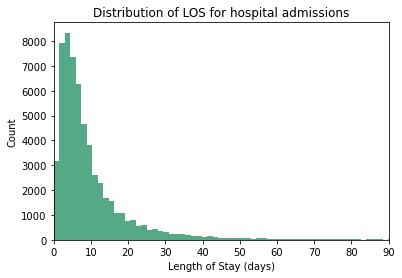

In [19]:
# Check LOS Distribution

plt.hist(df_admission.LOS, bins=200, color = '#55a987')
plt.xlim(0, 90)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length of Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [20]:
df_admission['ETHNICITY'].value_counts(dropna=False)

WHITE                                                       40939
BLACK/AFRICAN AMERICAN                                       5434
UNKNOWN/NOT SPECIFIED                                        4502
HISPANIC OR LATINO                                           1693
ASIAN                                                        1508
OTHER                                                        1507
UNABLE TO OBTAIN                                              809
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

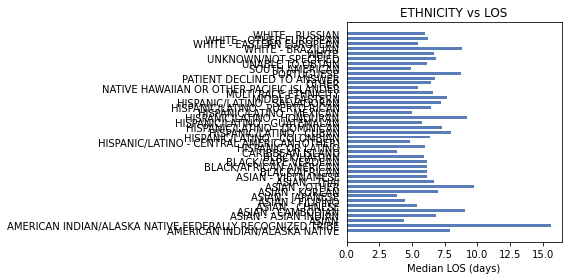

In [21]:
plotGroupby(df_admission, 'ETHNICITY','LOS')

In [22]:
# Reducing the number of ETHNICITY categories

df_admission['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df_admission['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df_admission['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC', inplace=True)
df_admission['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK', inplace=True)
df_admission['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER', inplace=True)
df_admission['ETHNICITY'].loc[~df_admission['ETHNICITY'].isin(df_admission['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER'
df_admission['ETHNICITY'].value_counts()

WHITE       41268
OTHER        7700
BLACK        5779
HISPANIC     2125
ASIAN        2006
Name: ETHNICITY, dtype: int64

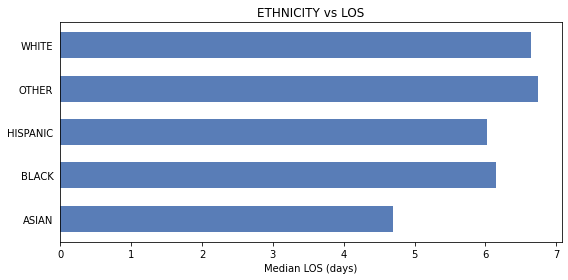

In [23]:
plotGroupby(df_admission, 'ETHNICITY','LOS')

In [24]:
df_admission['RELIGION'].value_counts(dropna=False)

CATHOLIC                  20580
NOT SPECIFIED             11738
UNOBTAINABLE               8242
PROTESTANT QUAKER          7121
JEWISH                     5307
OTHER                      2695
EPISCOPALIAN                771
GREEK ORTHODOX              459
NaN                         452
CHRISTIAN SCIENTIST         429
BUDDHIST                    267
MUSLIM                      225
JEHOVAH'S WITNESS           139
UNITARIAN-UNIVERSALIST      124
HINDU                       113
ROMANIAN EAST. ORTH          83
7TH DAY ADVENTIST            81
BAPTIST                      28
HEBREW                       16
METHODIST                     7
LUTHERAN                      1
Name: RELIGION, dtype: int64

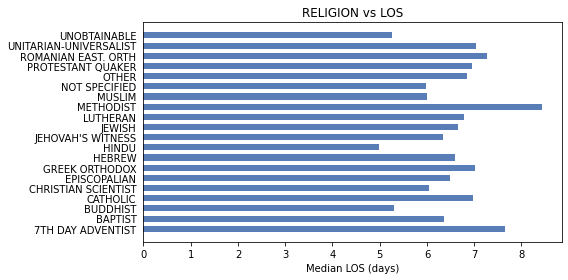

In [25]:
plotGroupby(df_admission, 'RELIGION','LOS')

In [26]:
df_admission['RELIGION'] = df_admission['RELIGION'].fillna('UNOBTAINABLE')
df_admission['RELIGION'].replace(['EPISCOPALIAN', 'GREEK ORTHODOX', 'CHRISTIAN SCIENTIST','BUDDHIST','MUSLIM','JEHOVAH\'S WITNESS', 
                       'UNITARIAN-UNIVERSALIST','HINDU','ROMANIAN EAST. ORTH','7TH DAY ADVENTIST','BAPTIST','HEBREW','METHODIST','LUTHERAN','BUDDHIST'], value='OTHER', inplace=True)
df_admission['RELIGION'].value_counts()

CATHOLIC             20580
NOT SPECIFIED        11738
UNOBTAINABLE          8694
PROTESTANT QUAKER     7121
OTHER                 5438
JEWISH                5307
Name: RELIGION, dtype: int64

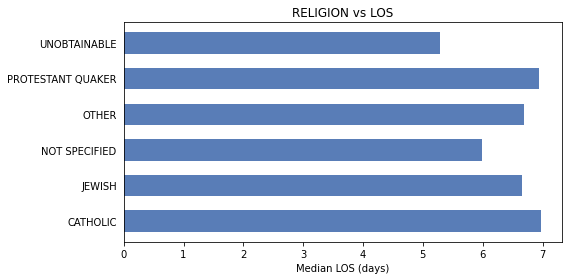

In [27]:
plotGroupby(df_admission, 'RELIGION','LOS')

In [28]:
df_admission['ADMISSION_TYPE'].value_counts(dropna=False)

EMERGENCY    41989
NEWBORN       7854
ELECTIVE      7702
URGENT        1333
Name: ADMISSION_TYPE, dtype: int64

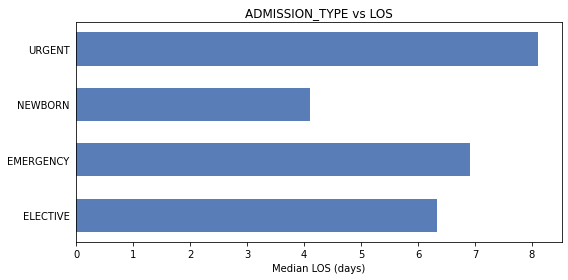

In [29]:
plotGroupby(df_admission, 'ADMISSION_TYPE','LOS')

In [30]:
df_admission['INSURANCE'].value_counts(dropna=False)

Medicare      28174
Private       22542
Medicaid       5778
Government     1781
Self Pay        603
Name: INSURANCE, dtype: int64

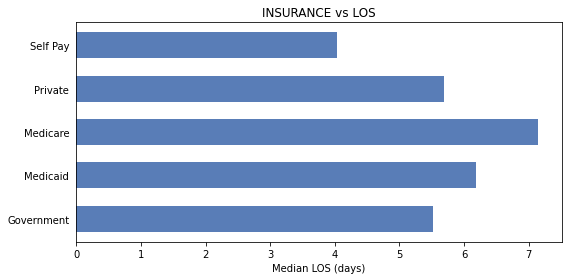

In [31]:
plotGroupby(df_admission, 'INSURANCE','LOS')

In [32]:
df_admission['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
NaN                  10097
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
UNKNOWN (DEFAULT)      343
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [33]:
df_admission['MARITAL_STATUS'] = df_admission['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df_admission['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24199
SINGLE               13238
UNKNOWN (DEFAULT)    10440
WIDOWED               7204
DIVORCED              3211
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

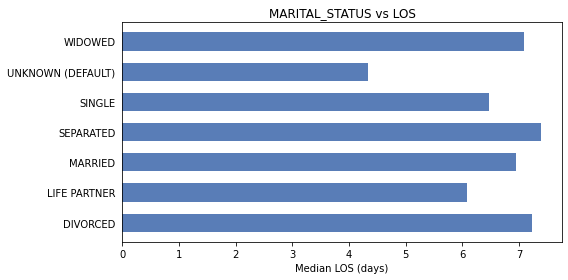

In [34]:
plotGroupby(df_admission, 'MARITAL_STATUS','LOS')

In [35]:
# Load Patient's info
df_patient = pd.read_csv('data/PATIENTS.csv')
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46520 entries, 0 to 46519
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       46520 non-null  int64 
 1   SUBJECT_ID   46520 non-null  int64 
 2   GENDER       46520 non-null  object
 3   DOB          46520 non-null  object
 4   DOD          15759 non-null  object
 5   DOD_HOSP     9974 non-null   object
 6   DOD_SSN      13378 non-null  object
 7   EXPIRE_FLAG  46520 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.8+ MB


In [36]:
df_patient.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [37]:
df_patient.drop(columns=['ROW_ID','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG'],inplace = True)


In [38]:
df_patient['GENDER'].value_counts(dropna=False)

M    26121
F    20399
Name: GENDER, dtype: int64

In [39]:
#enc= preprocessing.LabelEncoder()
#df_patient['GENDER'] = pd.Series(enc.fit_transform(df_patient.Gender.astype('str')))

In [40]:
# To Convert DOB to datetime type
df_patient['DOB'] = pd.to_datetime(df_patient['DOB'])
df_patient.head()

,SUBJECT_ID,GENDER,DOB
0,249,F,2075-03-13
1,250,F,2164-12-27
2,251,M,2090-03-15
3,252,M,2078-03-06
4,253,F,2089-11-26


In [41]:
df_admission = df_admission.merge(df_patient, how='inner', on='SUBJECT_ID')
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,GENDER,DOB
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,F,2131-05-07
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,M,2082-07-17
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,M,2082-07-17
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,M,2100-05-31
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,M,2101-11-21


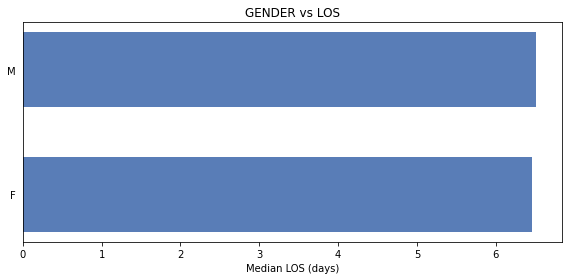

In [42]:
plotGroupby(df_admission, 'GENDER','LOS')

In [43]:
# Find the first admission time for each patient to calculate the age
df_admission_age_patient = df_admission[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_admission_age_patient.columns = ['SUBJECT_ID', 'FIRST_ADMITTIME']
df_admission_age_patient.head()

,SUBJECT_ID,FIRST_ADMITTIME
0,2,2138-07-17 19:04:00
1,3,2101-10-20 19:08:00
2,4,2191-03-16 00:28:00
3,5,2103-02-02 04:31:00
4,6,2175-05-30 07:15:00


In [44]:
df_admission = df_admission.merge(df_admission_age_patient, how='outer', on='SUBJECT_ID')
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,GENDER,DOB,FIRST_ADMITTIME
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,F,2131-05-07,2196-04-09 12:26:00
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,M,2082-07-17,2153-09-03 07:15:00
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,M,2082-07-17,2153-09-03 07:15:00
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,M,2100-05-31,2139-06-06 16:14:00
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,M,2101-11-21,2160-11-02 02:06:00


In [45]:
# Age is calculated as subtracting DOB from FIRST_ADMITTIME and divided by 365 

df_admission['FIRST_ADMITTIME'] = pd.to_datetime(df_admission['FIRST_ADMITTIME']).dt.date

df_admission['DOB'] = pd.to_datetime(df_admission['DOB']).dt.date

# since for patients above 89 years shifted the 'DOB' 300 years
df_admission['AGE'] = df_admission.apply(lambda e: (e['FIRST_ADMITTIME'] - e['DOB']).days/365, axis=1)

df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,GENDER,DOB,FIRST_ADMITTIME,AGE
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,F,2131-05-07,2196-04-09,64.969863
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,M,2082-07-17,2153-09-03,71.178082
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,M,2082-07-17,2153-09-03,71.178082
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,M,2100-05-31,2139-06-06,39.041096
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,M,2101-11-21,2160-11-02,58.989041


In [46]:
df_admission['AGE'].describe()

count    58878.000000
mean        64.045292
std         57.149329
min          0.000000
25%         42.934932
50%         61.205479
75%         75.441096
max        300.200000
Name: AGE, dtype: float64

In [47]:
#df_admission[df_admission.AGE < 0]
#df_admission[df_admission.AGE >100]
df_admission['AGE'] = np.where(df_admission['AGE'] < 0, 0, df_admission['AGE'])
df_admission['AGE'] = np.where(df_admission['AGE'] > 100,100, df_admission['AGE'])
df_admission['AGE'].describe()

count    58878.000000
mean        55.170636
std         27.791482
min          0.000000
25%         42.934932
50%         61.205479
75%         75.441096
max        100.000000
Name: AGE, dtype: float64

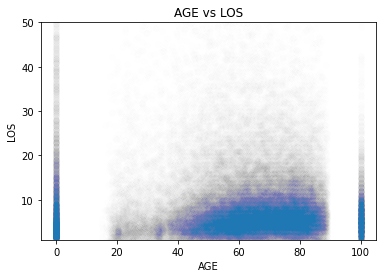

In [48]:
plotScatter(df_admission,'AGE', 'LOS')

In [49]:
# Create age categories
age_ranges = [(0, 13), (13, 26), (26, 46), (46, 66),(66,81),(81,100)]
for num, cat_range in enumerate(age_ranges):
    df_admission['AGE'] = np.where(df_admission['AGE'].between(cat_range[0],cat_range[1]), 
            num, df_admission['AGE'])
age_cat = {0: 'young_child', 1: 'youth', 2: 'adult', 3: 'middle_adult', 4:'senior_adult', 5:'oldage'}
df_admission['AGE'] = df_admission['AGE'].replace(age_cat)

In [50]:
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,GENDER,DOB,FIRST_ADMITTIME,AGE
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,F,2131-05-07,2196-04-09,middle_adult
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,M,2082-07-17,2153-09-03,senior_adult
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,M,2082-07-17,2153-09-03,senior_adult
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,M,2100-05-31,2139-06-06,adult
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,M,2101-11-21,2160-11-02,middle_adult


In [51]:
from sklearn import preprocessing
enc= preprocessing.LabelEncoder()
df_admission['GENDER'] = pd.Series(enc.fit_transform(df_admission.GENDER.astype('str')))

In [52]:
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,LOS,GENDER,DOB,FIRST_ADMITTIME,AGE
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,1.144444,0,2131-05-07,2196-04-09,middle_adult
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,5.496528,1,2082-07-17,2153-09-03,senior_adult
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,MARRIED,WHITE,BRAIN MASS,6.768056,1,2082-07-17,2153-09-03,senior_adult
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,SINGLE,WHITE,INTERIOR MYOCARDIAL INFARCTION,2.856944,1,2100-05-31,2139-06-06,adult
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,MARRIED,WHITE,ACUTE CORONARY SYNDROME,3.534028,1,2101-11-21,2160-11-02,middle_adult


In [53]:
# Load Diagnoses data of hospital admissions
df_diagnoses = pd.read_csv('data/DIAGNOSES_ICD.csv')
df_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ROW_ID      651047 non-null  int64  
 1   SUBJECT_ID  651047 non-null  int64  
 2   HADM_ID     651047 non-null  int64  
 3   SEQ_NUM     651000 non-null  float64
 4   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 24.8+ MB


In [54]:
df_diagnoses.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [55]:
df_diagnoses.drop(columns=['ROW_ID','SEQ_NUM'],inplace = True)


In [56]:
df_diagnoses['ICD9_CODE'].value_counts().count()

6984

In [57]:
# The main categories are the first 3 digits, so can trimout the rest
df_diagnoses['CODE_CATEGORY'] = df_diagnoses['ICD9_CODE']
df_diagnoses['CODE_CATEGORY'].isna().values.sum()


47

In [58]:
df_diagnoses['CODE_CATEGORY'] = df_diagnoses['CODE_CATEGORY'][~df_diagnoses['CODE_CATEGORY'].str.contains("[a-zA-Z]").fillna(False)]
df_diagnoses['CODE_CATEGORY'].fillna(value='999', inplace=True)
df_diagnoses['CODE_CATEGORY'].isna().values.sum()

0

In [59]:
df_diagnoses['CODE_CATEGORY'] = df_diagnoses['CODE_CATEGORY'].str.slice(start=0, stop=3, step=1)

df_diagnoses['CODE_CATEGORY'] = df_diagnoses['CODE_CATEGORY'].astype(int)
df_diagnoses['CODE_CATEGORY'].value_counts().count()

845

In [60]:
# ICD-9 Category ranges
icd_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# ICD-9 Categories
icd_cat = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-coding the ICD9_CODE categories
for num, cat_range in enumerate(icd_ranges):
    df_diagnoses['CODE_CATEGORY'] = np.where(df_diagnoses['CODE_CATEGORY'].between(cat_range[0],cat_range[1]), 
            num, df_diagnoses['CODE_CATEGORY'])
    
# Convert integer to category name using diag_dict
df_diagnoses['RE-CODED_CATEGORY'] = df_diagnoses['CODE_CATEGORY'].replace(icd_cat)
df_diagnoses.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,CODE_CATEGORY,RE-CODED_CATEGORY
0,109,172335,40301,6,circulatory
1,109,172335,486,7,respiratory
2,109,172335,58281,9,genitourinary
3,109,172335,5855,9,genitourinary
4,109,172335,4254,6,circulatory


In [61]:
# Create list of diagnoses for each HADM_ID
cat_list = df_diagnoses.groupby('HADM_ID')['RE-CODED_CATEGORY'].apply(list).reset_index()
adm_col = pd.get_dummies(cat_list['RE-CODED_CATEGORY'].apply(pd.Series).stack()).sum(level=0)
adm_col.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0


In [62]:
# Join the columns with HADM_ID
adm_col = adm_col.join(cat_list['HADM_ID'], how="outer")
adm_col.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,HADM_ID
0,0,2,0,2,5,2,0,2,0,0,0,0,2,0,0,0,1,100001
1,1,2,0,4,0,0,1,0,0,1,0,0,0,0,0,0,0,100003
2,0,0,0,0,1,0,0,2,1,1,0,1,0,0,0,3,0,100006
3,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,1,0,100007
4,1,7,0,0,3,0,0,7,0,0,0,0,0,0,0,0,0,100009


In [63]:
# Merge with df_admissions to have all the diagnoses for the admission
df_admission = df_admission.merge(adm_col, how='inner', on='HADM_ID')
df_admission.describe()

,SUBJECT_ID,HADM_ID,LOS,GENDER,blood,circulatory,congenital,digestive,endocrine,genitourinary,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
count,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,...,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000,58878.000000
mean,33761.791382,149966.149886,10.151266,0.558613,0.395988,2.379089,0.070587,0.654880,1.217178,0.556592,...,2.375879,0.419461,0.407589,0.218197,0.242756,0.393933,0.011261,0.439502,0.760777,0.158090
std,28092.613275,28882.995648,12.459774,0.496557,0.678072,2.278877,0.343045,1.163365,1.354162,0.872232,...,2.230712,0.835092,0.751588,0.561514,0.703287,0.772916,0.247395,1.324731,1.098550,0.525784
min,2.000000,100001.000000,0.001389,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.250000,124942.750000,3.755556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,24141.000000,149987.000000,6.489583,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,53862.750000,174958.000000,11.805556,1.000000,1.000000,4.000000,0.000000,1.000000,2.000000,1.000000,...,3.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,99999.000000,199999.000000,294.660417,1.000000,7.000000,17.000000,11.000000,11.000000,12.000000,7.000000,...,23.000000,11.000000,9.000000,7.000000,10.000000,8.000000,13.000000,16.000000,9.000000,9.000000


In [64]:
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,injury,mental,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,...,4,1,0,0,0,1,0,0,0,0
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,...,1,0,0,0,0,1,0,0,0,0
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,...,3,0,0,0,1,1,0,1,0,0
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,...,0,0,0,0,0,0,0,0,0,0
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,...,0,0,0,0,0,0,0,0,0,0


In [65]:

# Load ICU Stay details of hospital admissions
df_icustay = pd.read_csv('data/ICUSTAYS.csv')
df_icustay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61532 entries, 0 to 61531
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ROW_ID          61532 non-null  int64  
 1   SUBJECT_ID      61532 non-null  int64  
 2   HADM_ID         61532 non-null  int64  
 3   ICUSTAY_ID      61532 non-null  int64  
 4   DBSOURCE        61532 non-null  object 
 5   FIRST_CAREUNIT  61532 non-null  object 
 6   LAST_CAREUNIT   61532 non-null  object 
 7   FIRST_WARDID    61532 non-null  int64  
 8   LAST_WARDID     61532 non-null  int64  
 9   INTIME          61532 non-null  object 
 10  OUTTIME         61522 non-null  object 
 11  LOS             61522 non-null  float64
dtypes: float64(1), int64(6), object(5)
memory usage: 5.6+ MB


In [66]:
df_icustay.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [67]:
# Rmoving some unwanted columns
df_icustay.drop(columns=['ROW_ID','DBSOURCE','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID','INTIME','OUTTIME'],inplace = True)
df_icustay.head()


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LOS
0,268,110404,280836,MICU,3.2490
1,269,106296,206613,MICU,3.2788
2,270,188028,220345,CCU,2.8939
3,271,173727,249196,MICU,2.0600
4,272,164716,210407,CCU,1.6202


In [68]:
df_icustay.groupby('FIRST_CAREUNIT').median()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,LOS
FIRST_CAREUNIT,,,,
CCU,22964.5,150074.5,249373.5,2.19775
CSRU,24488.0,150225.0,250492.0,2.15290
MICU,26489.5,150368.0,250524.0,2.09550
NICU,15456.5,149206.5,249308.0,0.80250
SICU,30084.0,149744.0,248649.0,2.25220
TSICU,28716.0,148915.0,250685.0,2.11150


In [69]:
# Reducing to two categories ICU and NICU based on the above observation
df_icustay['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)
df_icustay.head()

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_CAREUNIT,LOS
0,268,110404,280836,ICU,3.2490
1,269,106296,206613,ICU,3.2788
2,270,188028,220345,ICU,2.8939
3,271,173727,249196,ICU,2.0600
4,272,164716,210407,ICU,1.6202


In [70]:
df_icustay['ICU_STAY'] = df_icustay['FIRST_CAREUNIT']
icustay_list = df_icustay.groupby('HADM_ID')['ICU_STAY'].apply(list).reset_index()
icustay_list.head()

,HADM_ID,ICU_STAY
0,100001,[ICU]
1,100003,[ICU]
2,100006,[ICU]
3,100007,[ICU]
4,100009,[ICU]


In [71]:
# Create column fo ICU_STAY
icu_col = pd.get_dummies(icustay_list['ICU_STAY'].apply(pd.Series).stack()).sum(level=0)
#icu_item[icu_item >= 1] = 1
icu_col = icu_col.join(icustay_list['HADM_ID'], how="outer")
icu_col.head()

,ICU,NICU,HADM_ID
0,1,0,100001
1,1,0,100003
2,1,0,100006
3,1,0,100007
4,1,0,100009


In [72]:
icu_col['ICU'].value_counts(dropna=False)


1    46642
0     7992
2     2757
3      326
4       54
5       10
6        3
7        2
Name: ICU, dtype: int64

In [73]:
icu_col[icu_col > 1] = 1
icu_col['ICU'].value_counts(dropna=False)

1    49794
0     7992
Name: ICU, dtype: int64

In [74]:
icu_col['NICU'].value_counts(dropna=False)

0    49794
1     7992
Name: NICU, dtype: int64

In [75]:
# Merge to admissions
df_admission = df_admission.merge(icu_col, how='outer', on='HADM_ID')
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU
0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
2,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN
3,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [76]:
df_admission['ICU'].isna().values.sum()

58878

In [77]:
df_admission['NICU'].isna().values.sum()

58878

In [78]:
df_admission['ICU'].value_counts(dropna=False)

NaN    58878
1.0    49794
0.0     7992
Name: ICU, dtype: int64

In [79]:
df_admission['NICU'].value_counts(dropna=False)

NaN    58878
0.0    49794
1.0     7992
Name: NICU, dtype: int64

In [80]:
df_admission['ICU'].fillna(value=0, inplace=True)
df_admission['NICU'].fillna(value=0, inplace=True)
df_admission['ICU'].value_counts(dropna=False)

0.0    66870
1.0    49794
Name: ICU, dtype: int64

In [81]:
df_admission['NICU'].value_counts(dropna=False)

0.0    108672
1.0      7992
Name: NICU, dtype: int64

In [82]:
df_admission.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,RELIGION,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU
0,22.0,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,UNOBTAINABLE,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.0,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,CATHOLIC,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23.0,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,CATHOLIC,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,24.0,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,PROTESTANT QUAKER,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25.0,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,UNOBTAINABLE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [83]:
df_admission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116664 entries, 0 to 116663
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   SUBJECT_ID          58878 non-null   float64       
 1   HADM_ID             116664 non-null  int64         
 2   ADMITTIME           58878 non-null   datetime64[ns]
 3   DISCHTIME           58878 non-null   datetime64[ns]
 4   DEATHTIME           5774 non-null    object        
 5   ADMISSION_TYPE      58878 non-null   object        
 6   ADMISSION_LOCATION  58878 non-null   object        
 7   DISCHARGE_LOCATION  58878 non-null   object        
 8   INSURANCE           58878 non-null   object        
 9   RELIGION            58878 non-null   object        
 10  MARITAL_STATUS      58878 non-null   object        
 11  ETHNICITY           58878 non-null   object        
 12  DIAGNOSIS           58853 non-null   object        
 13  LOS                 58878 non

In [84]:
# Remove LOS with negative number, likely entry form error
df_admission = df_admission[df_admission['LOS'] > 0]    

In [85]:
df_admission.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME','DISCHTIME','DEATHTIME','ADMISSION_LOCATION',
                'DISCHARGE_LOCATION','DIAGNOSIS','DOB'], inplace=True)
df_admission.head()

,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,LOS,GENDER,FIRST_ADMITTIME,AGE,blood,...,misc,muscular,neoplasms,nervous,pregnancy,prenatal,respiratory,skin,ICU,NICU
0,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,1.144444,0.0,2196-04-09,middle_adult,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,5.496528,1.0,2153-09-03,senior_adult,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,6.768056,1.0,2153-09-03,senior_adult,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,EMERGENCY,Private,PROTESTANT QUAKER,SINGLE,WHITE,2.856944,1.0,2139-06-06,adult,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,3.534028,1.0,2160-11-02,middle_adult,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Create dummy columns for categorical variables
col_pref = ['ADMSN', 'INSR', 'RELGN', 'ETHN', 'MS','AG']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'MARITAL_STATUS','AGE']
df = pd.get_dummies(df_admission, prefix=col_pref, columns=dummy_cols)
df.head()

,LOS,GENDER,FIRST_ADMITTIME,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,...,MS_SEPARATED,MS_SINGLE,MS_UNKNOWN (DEFAULT),MS_WIDOWED,AG_adult,AG_middle_adult,AG_oldage,AG_senior_adult,AG_young_child,AG_youth
0,1.144444,0.0,2196-04-09,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,5.496528,1.0,2153-09-03,0.0,4.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,6.768056,1.0,2153-09-03,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,2.856944,1.0,2139-06-06,0.0,2.0,0.0,1.0,1.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
4,3.534028,1.0,2160-11-02,0.0,3.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [87]:
df.isna().values.sum()

0

In [88]:
df.drop(columns=['FIRST_ADMITTIME'],inplace =True)
df.head()

,LOS,GENDER,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,...,MS_SEPARATED,MS_SINGLE,MS_UNKNOWN (DEFAULT),MS_WIDOWED,AG_adult,AG_middle_adult,AG_oldage,AG_senior_adult,AG_young_child,AG_youth
0,1.144444,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0,0,0,0,0,1,0,0,0,0
1,5.496528,1.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,6.768056,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0,0,0,0,0,0,0,1,0,0
3,2.856944,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,1,0,0,1,0,0,0,0,0
4,3.534028,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [89]:
scaler = RobustScaler()
df_columns = df.columns
data = df.values
df = scaler.fit_transform(data)
df = pd.DataFrame(data)
df.columns = df_columns
df.head()

,LOS,GENDER,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,...,MS_SEPARATED,MS_SINGLE,MS_UNKNOWN (DEFAULT),MS_WIDOWED,AG_adult,AG_middle_adult,AG_oldage,AG_senior_adult,AG_young_child,AG_youth
0,1.144444,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5.496528,1.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6.768056,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2.856944,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,3.534028,1.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [90]:
scaler = StandardScaler()
df_columns = df.columns
data = df.values
data = scaler.fit_transform(data)
df = pd.DataFrame(data)
df.columns = df_columns
df.head()

,LOS,GENDER,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,...,MS_SEPARATED,MS_SINGLE,MS_UNKNOWN (DEFAULT),MS_WIDOWED,AG_adult,AG_middle_adult,AG_oldage,AG_senior_adult,AG_young_child,AG_youth
0,-0.722878,-1.124982,-0.583997,-0.605167,-0.205767,-0.562923,-0.898850,-0.638129,-0.489948,0.728079,...,-0.09896,-0.538565,-0.464256,-0.37338,-0.354161,1.506020,-0.418132,-0.603421,-0.399426,-0.173522
1,-0.373584,0.888903,-0.583997,0.711282,-0.205767,-0.562923,-0.160379,0.508365,-0.489948,-0.616794,...,-0.09896,-0.538565,-0.464256,-0.37338,-0.354161,-0.664002,-0.418132,1.657218,-0.399426,-0.173522
2,-0.271533,0.888903,-0.583997,-0.166350,-0.205767,-0.562923,0.578091,-0.638129,-0.489948,0.279788,...,-0.09896,-0.538565,-0.464256,-0.37338,-0.354161,-0.664002,-0.418132,1.657218,-0.399426,-0.173522
3,-0.585435,0.888903,-0.583997,-0.166350,-0.205767,0.296660,-0.160379,-0.638129,-0.489948,-1.065086,...,-0.09896,1.856785,-0.464256,-0.37338,2.823574,-0.664002,-0.418132,-0.603421,-0.399426,-0.173522
4,-0.531093,0.888903,-0.583997,0.272466,-0.205767,-0.562923,-0.160379,-0.638129,-0.489948,-1.065086,...,-0.09896,-0.538565,-0.464256,-0.37338,-0.354161,1.506020,-0.418132,-0.603421,-0.399426,-0.173522


In [91]:
scaler = MinMaxScaler()
df_columns = df.columns
data = df.values
data = scaler.fit_transform(data)
df = pd.DataFrame(data)
df.columns = df_columns
df.head()

,LOS,GENDER,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,...,MS_SEPARATED,MS_SINGLE,MS_UNKNOWN (DEFAULT),MS_WIDOWED,AG_adult,AG_middle_adult,AG_oldage,AG_senior_adult,AG_young_child,AG_youth
0,0.003879,0.0,0.0,0.058824,0.0,0.000000,0.000000,0.000000,0.0,0.173913,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.018649,1.0,0.0,0.235294,0.0,0.000000,0.083333,0.142857,0.0,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.022964,1.0,0.0,0.117647,0.0,0.000000,0.166667,0.000000,0.0,0.130435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.009691,1.0,0.0,0.117647,0.0,0.090909,0.083333,0.000000,0.0,0.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.011989,1.0,0.0,0.176471,0.0,0.000000,0.083333,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [92]:
label = 'LOS'
nFolds = 10
model = GradientBoostingRegressor()
buildAndEvaluateModelKfold(df,label,nFolds,model)

R2-Score: 0.3581158330628429
MAE: 0.01944159342376065
MSE: 0.0011256026633482772
RMSE: 0.03322482869635261


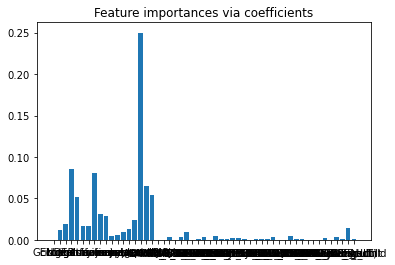

In [93]:
X = df.drop(columns=['LOS'])
# Target Variable- LOS
y = df['LOS']
dfr = pd.DataFrame( pd.DataFrame(X).values,columns= pd.DataFrame(X).columns)
lasso = LassoCV().fit(X, y)
importance = np.abs(lasso.coef_)
dfr.columns = pd.DataFrame(X).columns
feature_names = np.array(dfr.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [111]:
from sklearn.feature_selection import SelectFromModel

threshold = np.sort(importance)[-25] + 0.01

sfm = SelectFromModel(lasso, threshold=threshold).fit(dfr, y)

print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: ['circulatory' 'congenital' 'digestive' 'endocrine' 'genitourinary'
 'infectious' 'injury' 'mental' 'nervous' 'pregnancy' 'prenatal'
 'respiratory' 'skin' 'AG_young_child']


In [112]:
X_selected = dfr.loc(axis = 1)['circulatory', 'congenital', 'digestive', 'endocrine', 'genitourinary',
 'infectious', 'injury', 'mental', 'nervous', 'pregnancy', 'prenatal',
 'respiratory', 'skin', 'AG_young_child']
X_selected.head()

,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,nervous,pregnancy,prenatal,respiratory,skin,AG_young_child
0,0.058824,0.0,0.000000,0.000000,0.000000,0.0,0.173913,0.090909,0.125,0.0,0.0000,0.0,0.0,0.0
1,0.235294,0.0,0.000000,0.083333,0.142857,0.0,0.043478,0.000000,0.125,0.0,0.0000,0.0,0.0,0.0
2,0.117647,0.0,0.000000,0.166667,0.000000,0.0,0.130435,0.000000,0.125,0.0,0.0625,0.0,0.0,0.0
3,0.117647,0.0,0.090909,0.083333,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0000,0.0,0.0,0.0
4,0.176471,0.0,0.000000,0.083333,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0000,0.0,0.0,0.0


In [113]:
df_selected = X_selected.join(df['LOS'], how="outer")
df_selected.head()

,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,nervous,pregnancy,prenatal,respiratory,skin,AG_young_child,LOS
0,0.058824,0.0,0.000000,0.000000,0.000000,0.0,0.173913,0.090909,0.125,0.0,0.0000,0.0,0.0,0.0,0.003879
1,0.235294,0.0,0.000000,0.083333,0.142857,0.0,0.043478,0.000000,0.125,0.0,0.0000,0.0,0.0,0.0,0.018649
2,0.117647,0.0,0.000000,0.166667,0.000000,0.0,0.130435,0.000000,0.125,0.0,0.0625,0.0,0.0,0.0,0.022964
3,0.117647,0.0,0.090909,0.083333,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0000,0.0,0.0,0.0,0.009691
4,0.176471,0.0,0.000000,0.083333,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.0000,0.0,0.0,0.0,0.011989


In [114]:
buildAndEvaluateModelKfold(df_selected,label,nFolds,model)

R2-Score: 0.34417423071824255
MAE: 0.019637092628327753
MSE: 0.0011444457378934937
RMSE: 0.033533233502192644


In [95]:
# Model creation for Length of Stay
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
import seaborn as sns
# Prediction Features
X = df.drop(columns=['LOS'])
# Target Variable- LOS
y = df['LOS']
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .20, 
                                                    random_state = 0)

model =  GradientBoostingRegressor()
model.fit(X_train, y_train)
    
# Make predictions with model
y_pred = model.predict(X_test)   
resultscore = r2_score(y_test, y_pred)

In [96]:
resultscore

0.37580808593977644